# ⌚️ Inferring Relationships in Wearable-Sourced Health Data

Ths notebook explores, models and attempts to explain latent patterns in data sourced from my Apple Watch. 

❗️ TODO UPDATE THIS LINK TO POINT TO MY COLAB NOTEBOOK

[![Open In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AIPI-590-XAI/Duke-AI-XAI/blob/dev/explainable-ml-example-notebooks/local_explanations.ipynb)

## Dependencies

In [159]:
!pip install xgboost apple-health-parser anchor-exp git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython

  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /private/var/folders/rj/1f5wy6qj5r317rr06jymfqth0000gn/T/pip-install-affsv1vy/alepython_305401aa7d004de5adc52059637eb1bc
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /private/var/folders/rj/1f5wy6qj5r317rr06jymfqth0000gn/T/pip-install-affsv1vy/alepython_305401aa7d004de5adc52059637eb1bc
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


## Data

In [160]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm 

Define an extraction step to ingest the raw data, which we'll skil if the post-processed data is available to avoid oversharing PII.

### Extraction 

Apple stores health data in a proprietary XML format which can be exported in bulk. 

Note: Parsing the HealthKit format below is done with the 

We'll limit the temporal analysis required here by summing within a calendar day. This will yield some reasonable and intuitve metrics we can try to predict off of. The consolidation of the relevant tables is surprisingly straightforward once we apply this constraint: 

HKCategoryTypeIdentifierSleepAnalysis
- on end_date got range hours of sleep 

HKQuantityTypeIdentifierActiveEnergyBurned
- on end_date burned value calories
- sum value by date

HKQuantityTypeIdentifierAppleExerciseTime
- on end_date exercised for 1 min
- sum value by end_date

HKQuantityTypeIdentifierAppleStandTime
- on end_date stood for value mins
- sum value on end_date

HKQuantityTypeIdentifierBasalEnergyBurned
- on end_date calories burned on end_date
- sum value on end_date

HKQuantityTypeIdentifierFlightsClimbed
- on end_date 1 flight climbed 
- sum value on end_date

HKQuantityTypeIdentifierHeartRate
- instantaneous HR measurements at end_date
- perhaps take max value of columnd within date

HKQuantityTypeIdentifierOxygenSaturation
- instantaneous on end date
- take max and min for the day

HKQuantityTypeIdentifierPhysicalEffort
- instanteous measure of energy on end_date
- take max and min for the day 

HKQuantityTypeIdentifierRespiratoryRate
- instantaneous 
- take average? 

HKQuantityTypeIdentifierRestingHeartRate
- value has an average over a short period (length of end_date - start_date)
- take min and max for the day 

HKQuantityTypeIdentifierStepCount
- value for short window 
- sum for end_date

HKQuantityTypeIdentifierTimeInDaylight
- sum value for end_date

In [161]:
INCLUDE_FLAGS = (
    "HKCategoryTypeIdentifierSleepAnalysis",
    "HKQuantityTypeIdentifierActiveEnergyBurned",
    "HKQuantityTypeIdentifierAppleExerciseTime",
    "HKQuantityTypeIdentifierAppleStandTime",
    "HKQuantityTypeIdentifierBasalEnergyBurned",
    "HKQuantityTypeIdentifierFlightsClimbed",
    "HKQuantityTypeIdentifierHeartRate",
    "HKQuantityTypeIdentifierOxygenSaturation",
    "HKQuantityTypeIdentifierPhysicalEffort",
    "HKQuantityTypeIdentifierRespiratoryRate",
    "HKQuantityTypeIdentifierRestingHeartRate",
    "HKQuantityTypeIdentifierStepCount",
    "HKQuantityTypeIdentifierTimeInDaylight",
)

❗️ The library we use for parsing HealthKit data reliese on some enum behavior that wasn't stabilized in python 3.11, however Colab is still running on 3.11 so we can't upgrade. Below GPT-5-supplied workaround to patch enum behavior is necessary if a full parsing operation is run (shoudn't be necessary if running on colab though)

In [162]:
import sys, enum, threading
if (3, 11) <= sys.version_info < (3, 12):
    _old_contains = enum.EnumMeta.__contains__
    _guard = threading.local(); _guard.active = False

    def _patched_contains(cls, member):
        # avoid recursive re-entry
        if getattr(_guard, "active", False):
            # Fall back to equality semantics—do NOT recurse
            try:
                return any(member == m or str(member) == m.value for m in cls)  # best-effort
            except Exception:
                return False
        try:
            return _old_contains(cls, member)
        except TypeError:
            try:
                _guard.active = True
                # emulate 3.12: try coercion; True if coercible, else False
                cls(member)  # may raise ValueError
                return True
            except Exception:
                return False
            finally:
                _guard.active = False

    enum.EnumMeta.__contains__ = _patched_contains


Abstract the XML-based format and emit a dict of dataframes for each of our target tables. 

In [163]:
from apple_health_parser.utils.parser import Parser

def parse_healthkit_data(path, output_dir="./data/out", flags=INCLUDE_FLAGS): 
    """
    Go through the raw data with the help of the above import. 

    NOTE: HealthKit parsing logic courtesy of GPT-5, see https://chatgpt.com/share/68d811d3-6e00-8013-bca7-e39aa6e6f106
    """
    parser = Parser(export_file=path, output_dir=output_dir, overwrite=True)

    flags = [f for f in parser.flags if f.startswith(flags)]

    dfs = {}
    errors = {}

    for f in tqdm(flags):
        try:
            parsed = parser.get_flag_records(flag=f)
            if not parsed.records.empty:
                dfs[f] = parsed.records
        except Exception as e:
            errors[f] = repr(e)

    print(f"Extracted {len(dfs)} tables with {len(errors)} errors")

    return dfs

In [164]:
def aggregate_by_date(df, date_col, val_col, op="sum", name=None):
    """
    Aggregate dataframe column by date, summing

    NOTE:  Date aggregation syntax courtesy of gpt-5, see https://chatgpt.com/share/68d82165-543c-8013-a1c4-4d5ac9d68410
    """
    groups = df.groupby(df[date_col].dt.date)
        
    agg_df = None
    match(op):         
        case "min" : 
            agg_df = groups[val_col].min().reset_index()
        case "max" : 
            agg_df = groups[val_col].max().reset_index()
        case "mean" : 
            agg_df = groups[val_col].mean().reset_index()
        case "sum" | None | _ : 
            agg_df = groups[val_col].sum().reset_index()

    kwargs = { 'columns': [name] } if name else {}
    return pd.DataFrame(agg_df[val_col].values, index=agg_df[date_col].values, **kwargs)

In [165]:
def process_healthkit_data(table_dfs):
    """
    Given a dict of dataframes with our target data container, filter and construct a unifed dataframe 
    that aggregates data by date. Note the tight coupling with parse flags above. 
    """

    agg_dfs = {}
    
    # Sleep categories need to be filtered, but otherwise we should be fine without (filtering rows) based on samples inspected
    sleep = table_dfs['HKCategoryTypeIdentifierSleepAnalysis']
    condition = (sleep.value != "HKCategoryValueSleepAnalysisInBed") & (sleep.value != "HKCategoryValueSleepAnalysisAwake")
    agg_dfs['sleep'] = aggregate_by_date(sleep[condition], date_col="end_date", val_col="range", op="sum", name="sleep_h") 

    agg_dfs['energy'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierActiveEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="active_cal") 
    agg_dfs['exercise'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleExerciseTime'], date_col="end_date", val_col="value", op="sum", name="exercise_m") 
    agg_dfs['stand'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierAppleStandTime'], date_col="end_date", val_col="value", op="sum", name="stand_m") 
    agg_dfs['basal'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierBasalEnergyBurned'], date_col="end_date", val_col="value", op="sum", name="basal_cal") 
    agg_dfs['flights'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierFlightsClimbed'], date_col="end_date", val_col="value", op="sum", name="flights") 
    agg_dfs['hr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierHeartRate'], date_col="end_date", val_col="value", op="max", name="max_hr") 
    agg_dfs['o2'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierOxygenSaturation'], date_col="end_date", val_col="value", op="min", name="min_o2") 
    agg_dfs['effort'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierPhysicalEffort'], date_col="end_date", val_col="value", op="sum", name="activity_mets") 
    agg_dfs['rr'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRespiratoryRate'], date_col="end_date", val_col="value", op="mean", name="avg_rr") 
    agg_dfs['resting'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierRestingHeartRate'], date_col="end_date", val_col="value", op="mean", name="avg_resting_hr") 
    agg_dfs['step'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierStepCount'], date_col="end_date", val_col="value", op="sum", name="steps") 
    agg_dfs['daylight'] = aggregate_by_date(table_dfs['HKQuantityTypeIdentifierTimeInDaylight'], date_col="end_date", val_col="value", op="sum", name="daylight_h") 

    # Migrate to float value for sleep duration from timedelta.  NOTE: GPT-5-supplied float conversion
    agg_dfs['sleep'].sleep_h = agg_dfs['sleep'].sleep_h / np.timedelta64(1, "h")

    # Join our table DFs
    df = pd.DataFrame()
    df = df.join(list(agg_dfs.values()), how="outer")
    #macro_df.reset_index(names='date', inplace=True)

    # Coax the string value for the date back to a numeric and sort. NOTE: type conversion courtesy of GPT-5
    df.index = pd.to_datetime(df.index, errors="coerce")
    df.sort_index(inplace=True)

    return df

If we can restore the processed data, do so, otherwise mine our data out of the full HealthKit export.

In [166]:
raw_dataset = "./data/export.zip"
processed_dataset = "./data/health.csv"

df = None
if os.path.exists(processed_dataset):
    df = pd.read_csv(processed_dataset)
else:         
    table_dfs = parse_healthkit_data(raw_dataset)
    df = process_healthkit_data(table_dfs)
    
    df.reset_index(names="date", inplace=True)
    df.to_csv(processed_dataset)

### Exploration

Text(0.5, 1.0, 'Feature density for 2018-04-03 to 2025-09-27')

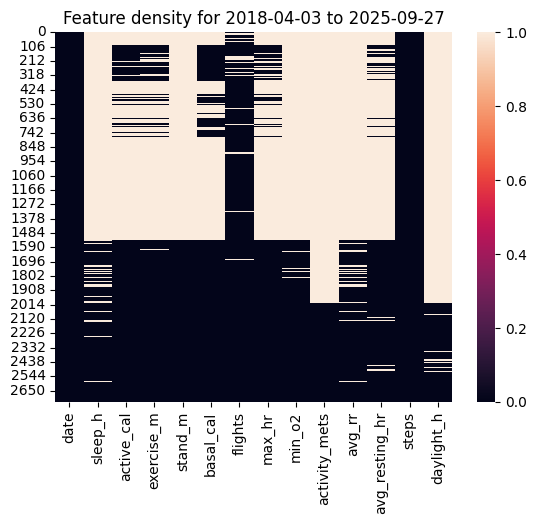

In [167]:
# Inspect for sparsity
ax = sns.heatmap(df.isna())
ax.set_title(f"Feature density for {df.iloc[0].date} to {df.iloc[-1].date}")

There's way too much sparsity in our features to attempt modeling or exploration. Slice this down to a subset that has higher fidelity. 

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

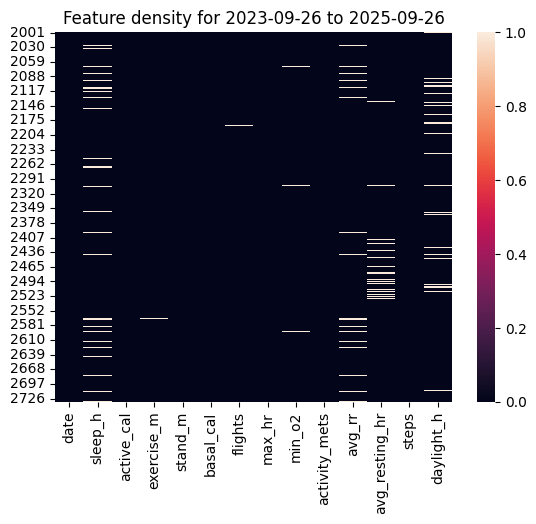

In [168]:
start_ix = df[~df.activity_mets.isna()].index[0]
df2 = df.iloc[start_ix:-1]
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")


Because this is my health data, there are relatively few gaps, and I know, eh ... myself reasonably well, we'll impute values here using the mean for each. 

In [169]:
df2.sleep_h = df2.sleep_h.fillna(value=df2.sleep_h.mean())
df2.exercise_m = df2.exercise_m.fillna(value=df2.exercise_m.mean())
df2.flights = df2.flights.fillna(value=df2.flights.mean())
df2.min_o2 = df2.min_o2.fillna(value=df2.min_o2.mean())
df2.avg_rr = df2.avg_rr.fillna(value=df2.avg_rr.mean())
df2.avg_resting_hr = df2.avg_resting_hr.fillna(value=df2.avg_resting_hr.mean())
df2.daylight_h = df2.daylight_h.fillna(value=df2.daylight_h.mean())

Text(0.5, 1.0, 'Feature density for 2023-09-26 to 2025-09-26')

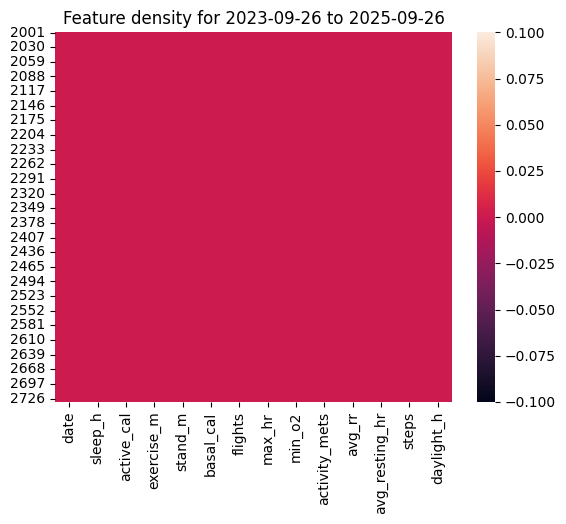

In [170]:
ax = sns.heatmap(df2.isna())
ax.set_title(f"Feature density for {df2.iloc[0].date} to {df2.iloc[-1].date}")

We now have a glorious Nan-free dataset that spans two years (exactly, wow!)

Let's do something simple but meaningful, predict how much sleep I'll get the next day. Add a target variable after dropping the last row (no target available for the last day of the dataset)

In [171]:
reg_target = df2.sleep_h.iloc[1:].copy()

# https://stackoverflow.com/questions/26921651/how-to-delete-the-last-row-of-data-of-a-pandas-dataframe
df2.drop(df2.tail(1).index, inplace=True)

df2['sleep_h_tomorrow'] = reg_target.to_numpy()

Next investigate any correlations between predictors (and target). 

In [172]:
def make_mask(shape): 
    """
    Make a correlation matrix mask to pass to seaborn.heatmap that hides
    redundant values in the plot. 
    """
    mask = np.zeros(shape)
    for col in range(0, shape[0]): 
        for row in range(0, shape[1]):
            if col <= row: 
                mask[col, row] = True
    return mask 

<Axes: >

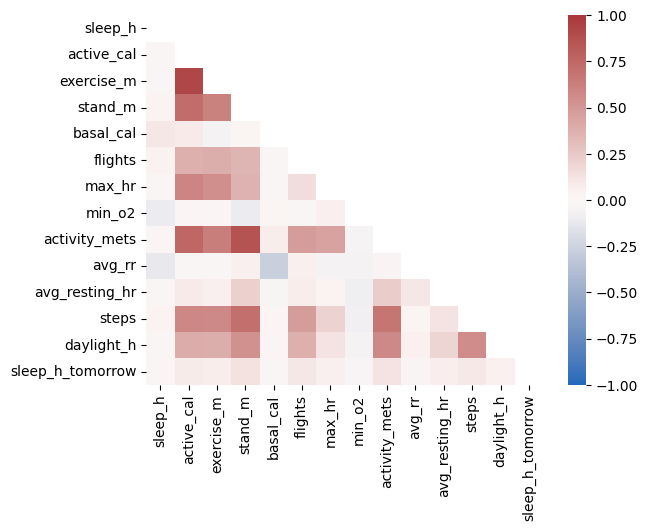

In [173]:
corr = df2.drop(["date"], axis=1).corr()
sns.heatmap(corr, vmin=-1, vmax=1, cmap="vlag", mask=make_mask(corr.shape))

We have a few strong, positive correlations: 
- Exercise minutes moves with active calories which is intuitive, but they aren't necessarily the same as exercise may be a function of tracked workouts -- consider omitting `active_cal` though
- METs are correlated with stand minutes -- the more time up and about, the more METs burned -- consider omitting `stand_m`

This collinearity presents some minor challenges depending on the model. For example, weights learned by linear regression could be inflated or suppressed for features that move together (colinear) like exercise and active calories. Suppressing one shifts the burden of explainability to us (the humans), so be clear there's a rationale for every feature removed. 

In [174]:
df2

date   sleep_h  active_cal  exercise_m  stand_m  basal_cal  \
2001  2023-09-26  7.083333     529.270        13.0    113.0   1926.090   
2002  2023-09-27  8.141667     380.001        16.0     76.0   1944.372   
2003  2023-09-28  6.583333     485.088         6.0     52.0   2024.562   
2004  2023-09-29  6.166667     477.532        15.0    108.0   1969.511   
2005  2023-09-30  9.133333     828.947        85.0    172.0   1859.237   
...          ...       ...         ...         ...      ...        ...   
2727  2025-09-21  6.413611     969.809        97.0    149.0   1974.742   
2728  2025-09-22  5.625833     958.320        90.0    194.0   1960.212   
2729  2025-09-23  6.024722     504.973        11.0    122.0   1943.365   
2730  2025-09-24  6.993056     490.431        21.0     95.0   1891.894   
2731  2025-09-25  5.205556    1086.919       113.0    158.0   1976.054   

      flights   max_hr  min_o2  activity_mets     avg_rr  avg_resting_hr  \
2001      5.0  116.000    0.90          254.1  12.670455            50.0   
2002      4.0  117.000    0.92         1114.0  12.469388            55.0   
2003      6.0  111.000    0.94         1268.9  12.287500            56.0   
2004      8.0  108.000    0.94         1479.0  12.657895            56.0   
2005      4.0  125.101    0.91         2077.2  12.305085            59.0   
...       ...      ...     ...            ...        ...             ...   
2727     20.0  139.000    0.93         2285.5  12.587500            49.0   
2728     31.0  170.000    0.91         2760.3  12.132353            56.0   
2729      8.0  100.000    0.94         1541.9  12.441860            50.0   
2730     19.0  129.000    0.92         1455.4  11.918605            54.0   
2731      9.0  163.000    0.93         2089.4  12.046875            56.0   

        steps  daylight_h  sleep_h_tomorrow  
2001  12419.0   106.93037          8.141667  
2002   9718.0    52.00000          6.583333  
2003   5665.0    10.00000          6.166667  
2004  12215.0    78.00000          9.133333  
2005  10772.0   155.00000          7.650000  
...       ...         ...               ...  
2727   9021.0   157.00000          5.625833  
2728  13841.0    95.00000          6.024722  
2729   7830.0    42.00000          6.993056  
2730   8274.0    53.00000          5.205556  
2731  11772.0   110.00000          6.706568  

[731 rows x 15 columns]

Now look at individual and pairwise distributions of the features. 

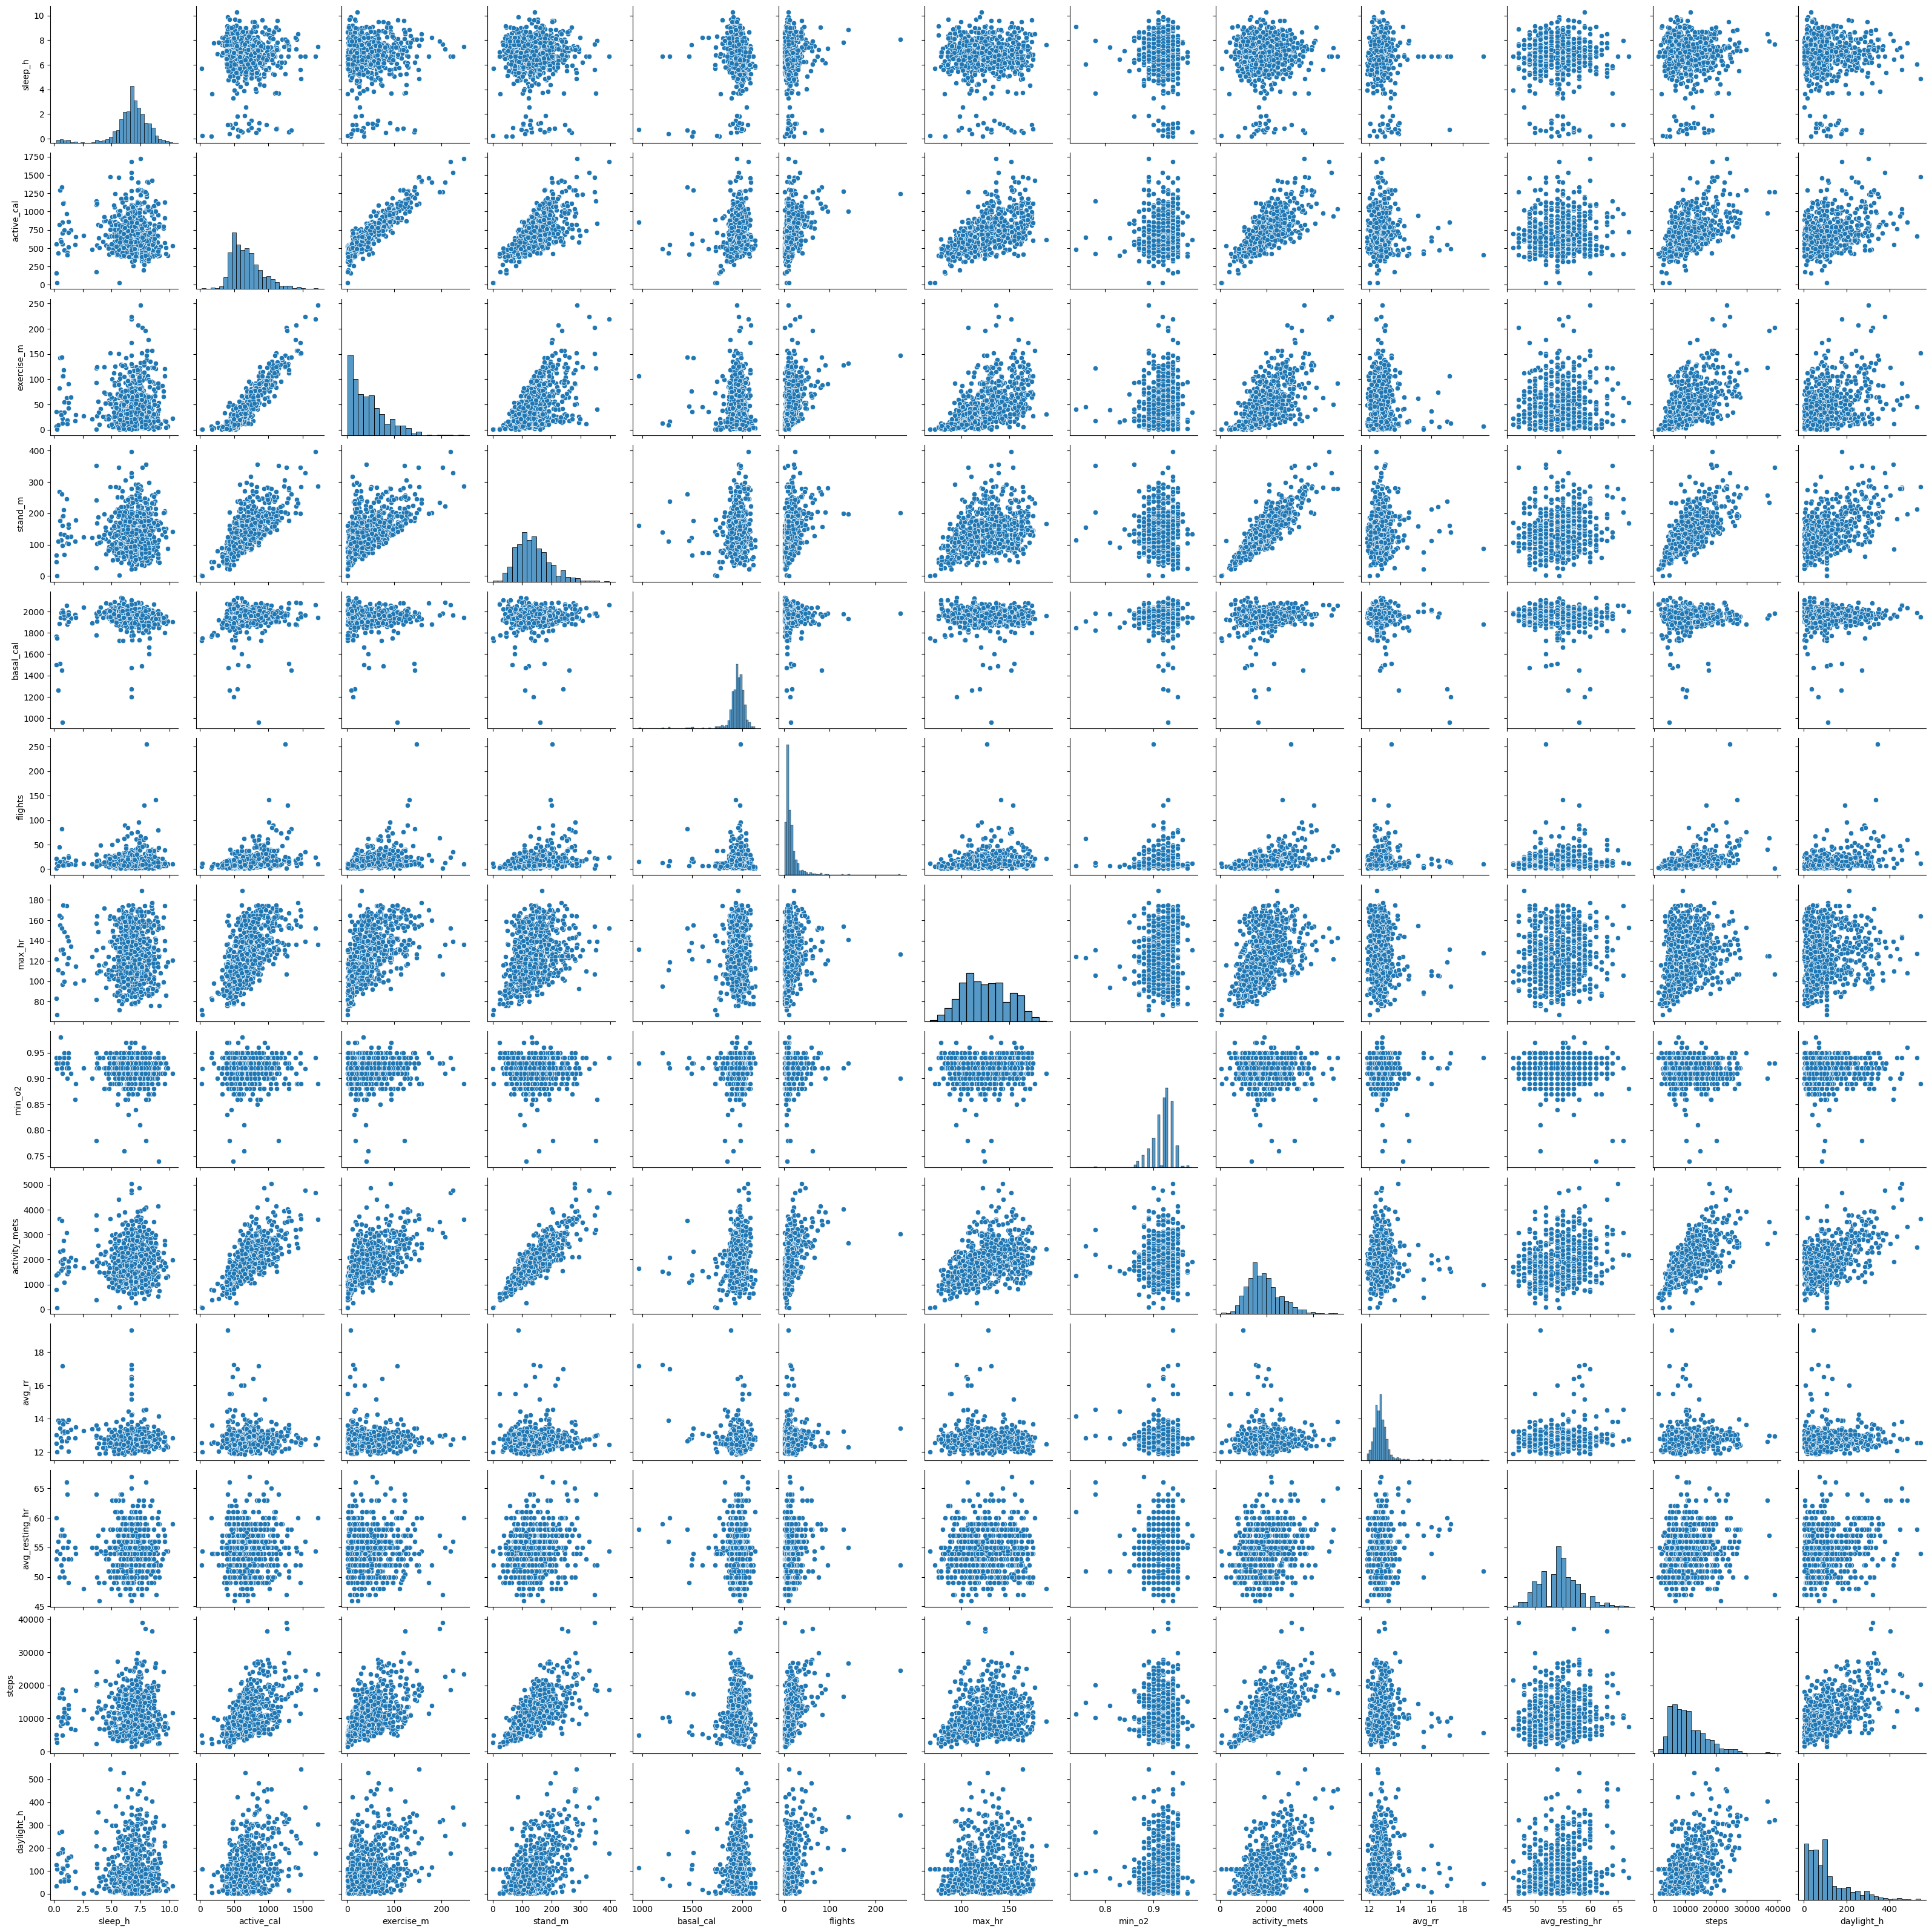

In [175]:
sns.pairplot(df2.drop(['sleep_h_tomorrow'], axis=1))


Most of the data looks normally distributred, usefully, save `exercise_m`. Some collinearity already noted above is evident, but none are so pronounced that there's clear evidence for dropping the feature. Continue on to modeling.  

The above data implicitly supports a regression task. But let's also look at a classification task to discretize the output and help me predict good/bad/ugly sleep. I know below 6 is a bad day, 6-7.5 is good, and 8 is sitting pretty.

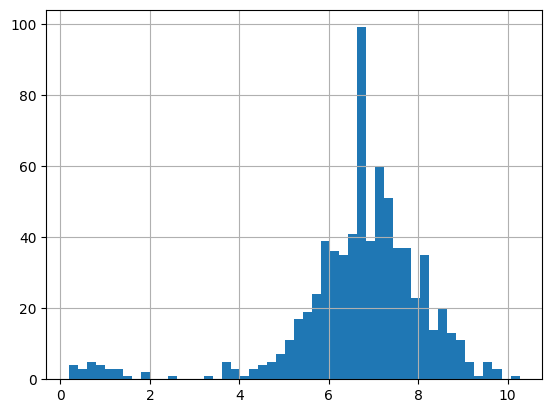

In [176]:
_ = df2.sleep_h_tomorrow.hist(bins=50)

In [177]:
sleep_classes = ["<6.5", "6.5-7.5", ">7.5"]
def classify_sleep(sleep): 
    """
    Created categoricals for our sleep target 
    """
    if sleep < 6.5: 
        return 0
    elif sleep < 7.5: 
        return 1
    else: 
        return 2

In [178]:
df2['sleep_quality_tomorrow'] = df2.sleep_h_tomorrow.apply(classify_sleep)

## Modeling

In [179]:
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

We'll use a support vector machine to model the relationship, looking at both regression and classification tasks.  

NOTE: snippets here from https://github.com/AIPI-590-XAI/Duke-AI-XAI/blob/main/explainable-ml-example-notebooks/local_explanations.ipynb and SKL docs, e.g. https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

Set aside tomorrow's sleep value as our target value and split the data. 

In [180]:
reg_target = "sleep_h_tomorrow"
cls_target = "sleep_quality_tomorrow"
X = df2.drop([reg_target, cls_target, "date"], axis=1)
y_reg = df2[reg_target]
y_cls = df2[cls_target]

X_train, X_test, y_reg_train, y_reg_test = train_test_split(X, y_reg, test_size=0.2, random_state=42)
_, _, y_cls_train, y_cls_test = train_test_split(X, y_cls, test_size=0.2, random_state=42)

In [181]:
display("Predictors:", X_train.head()) 
display("Regression Target:", y_reg_train.head())
display("Classification Target:", y_cls_train.head())

'Predictors:'

sleep_h  active_cal  exercise_m  stand_m  basal_cal  flights  max_hr  \
2683  6.383333     580.571        38.0    108.0   1944.049      8.0    97.0   
2251  7.608333     324.867         5.0     70.0   1873.624      6.0   111.0   
2337  6.966667     580.337        49.0     95.0   1870.349     28.0   132.0   
2261  7.558333     632.159        28.0    134.0   2009.267     11.0   159.0   
2544  7.591667     359.905         6.0     43.0   1923.356     12.0   124.0   

      min_o2  activity_mets     avg_rr  avg_resting_hr    steps  daylight_h  
2683    0.91         1495.2  12.532258            54.0  11772.0        59.0  
2251    0.94          899.1  12.970588            57.0   7120.0        17.0  
2337    0.92         1594.3  12.645833            51.0  15760.0        73.0  
2261    0.91         1723.8  12.500000            58.0   6619.0        57.0  
2544    0.92          857.3  12.489796            50.0   5453.0        37.0

'Regression Target:'

2683    0.691667
2251    7.116667
2337    7.441667
2261    7.650000
2544    7.050000
Name: sleep_h_tomorrow, dtype: float64

'Classification Target:'

2683    0
2251    1
2337    1
2261    2
2544    1
Name: sleep_quality_tomorrow, dtype: int64

### Regression 

Scale out data and fit the regression model. 

In [182]:
reg_pipe = make_pipeline(StandardScaler(), SVR(C=2.0, epsilon=0.1))
reg_pipe.fit(X_train, y_reg_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svr', SVR(C=2.0))])

See how the model does!

In [183]:
reg_preds = reg_pipe.predict(X_test)

Text(0, 0.5, 'Actual Sleep Hours')

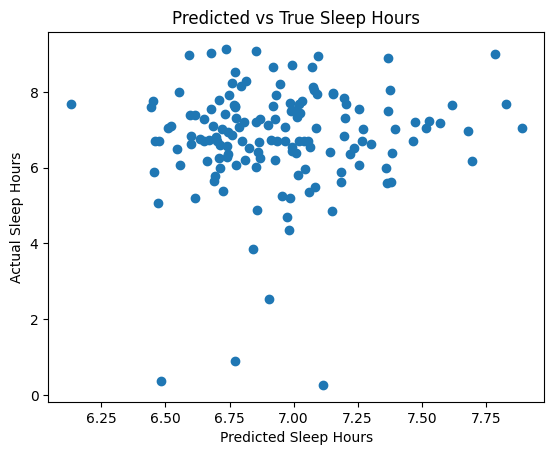

In [184]:
fig, ax = plt.subplots()
ax.scatter(x=reg_preds, y=y_reg_test)
ax.set_title("Predicted vs True Sleep Hours")
ax.set_xlabel("Predicted Sleep Hours")
ax.set_ylabel("Actual Sleep Hours")

In [185]:
errors = y_reg_test - reg_preds
mae = mean_absolute_error(y_reg_test, reg_preds)
mse = mean_squared_error(y_reg_test, reg_preds)

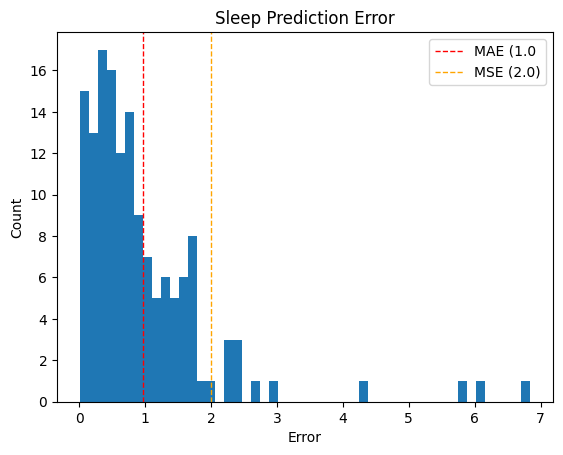

In [186]:
fig, ax = plt.subplots()
ax.hist(np.abs(errors), bins=50)
ax.set_title("Sleep Prediction Error")
ax.set_xlabel("Error")
ax.set_ylabel("Count")
ax.axvline(x=mae, color='red', linestyle='--', linewidth=1, label=f"MAE ({mae:.1f}")
ax.axvline(x=mse, color='orange', linestyle='--', linewidth=1, label=f"MSE ({mse:.1f})")
ax.legend()

Overall not horrific. Here we can see how useful MAE is when trying to map the error to our intuition. Being less than an hour off of every prediction is straightforward to interpret. 

### Classification

In [187]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Here will quickly fit a classifier and see how it fares on a categorical prediction. 

In [188]:
cls_pipe = make_pipeline(StandardScaler(), SVC(C=2.0))
cls_pipe.fit(X_train, y_cls_train)
cls_preds = cls_pipe.predict(X_test)

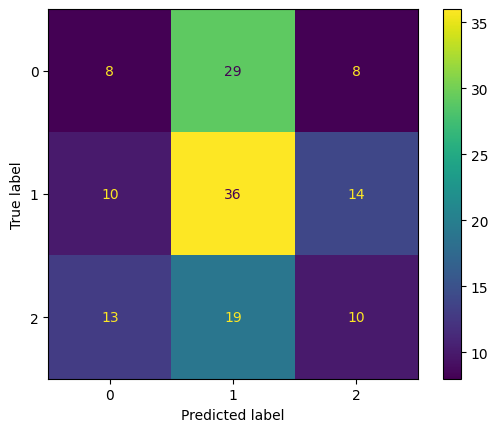

In [189]:
def plot_confusion_matrix(y, y_hat): 
    """
    Render a confusion matrix 
    """
    conmat = confusion_matrix(y, y_hat)
    cmd = ConfusionMatrixDisplay(confusion_matrix=conmat)
    cmd.plot()

plot_confusion_matrix(y_cls_test, cls_preds)

The classifier is a little less interesting due to the loss of fidelity on the output. The classes are meaningful, but the distinction between 6.49 and 6.51 hours of sleep isn't much, yet here it's bured in the class labels. 

While we have some instincts about what factors support (and detract) from sleep, it's not clear which for me personally are the most pronounced. We'll look at a few different explainability methods to help make sense of the relevance of each feature in the model. 

## Explanations

### Individual Contribution Expectation (ICE) 

We'll first look at individual features by way of ICE plots. 

In [190]:
from sklearn.inspection import PartialDependenceDisplay

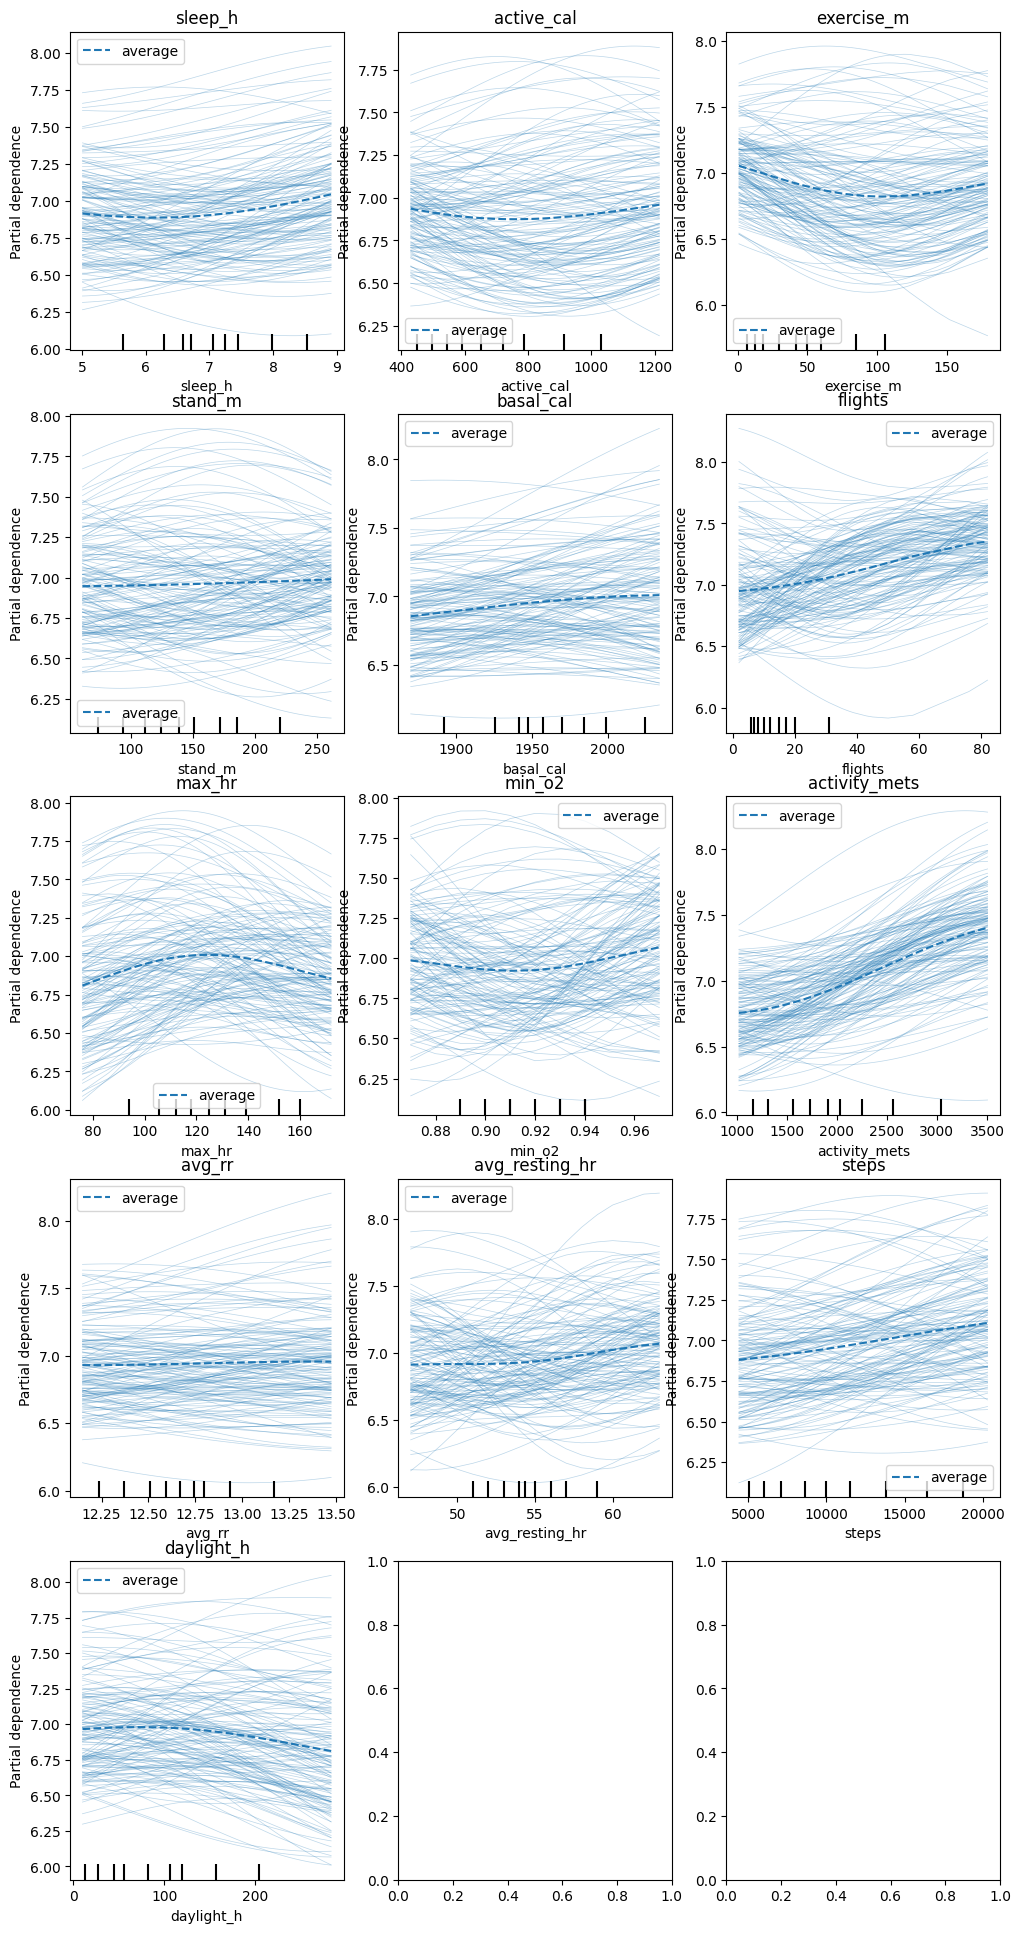

In [191]:
h = 5
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
for i, feature in enumerate(X_test.columns): 
    row = i // w
    col = i % w    
        
    pdp = PartialDependenceDisplay.from_estimator(reg_pipe, X_test, [feature], kind='both', ax=axs[row, col])
    axs[row, col].set_title(feature)    

plt.show()
fig.tight_layout()
    

Some interesting possible explanations emerge for the amount of sleep I get: 
- Positive relationship with sleep from the day prior: the more I slept yesterday, the more I'm likely to sleep on the day of. Perhaps sleep the day before is a proxy for time of year or times when I'm generally more active. 
- Positive relationship to steps, METs, which both could be a proxy for exercise, but interestingly exercise has a negative influence on sleep up at lower duration (of exercise)
- Positive influence of energy exerted (METs) on sleep duration, but unclear how to interpret this given the U-shaped exercise relationship mentioned above. 

We'll also render a centered ICE plot to see if the relationship are more evident. 

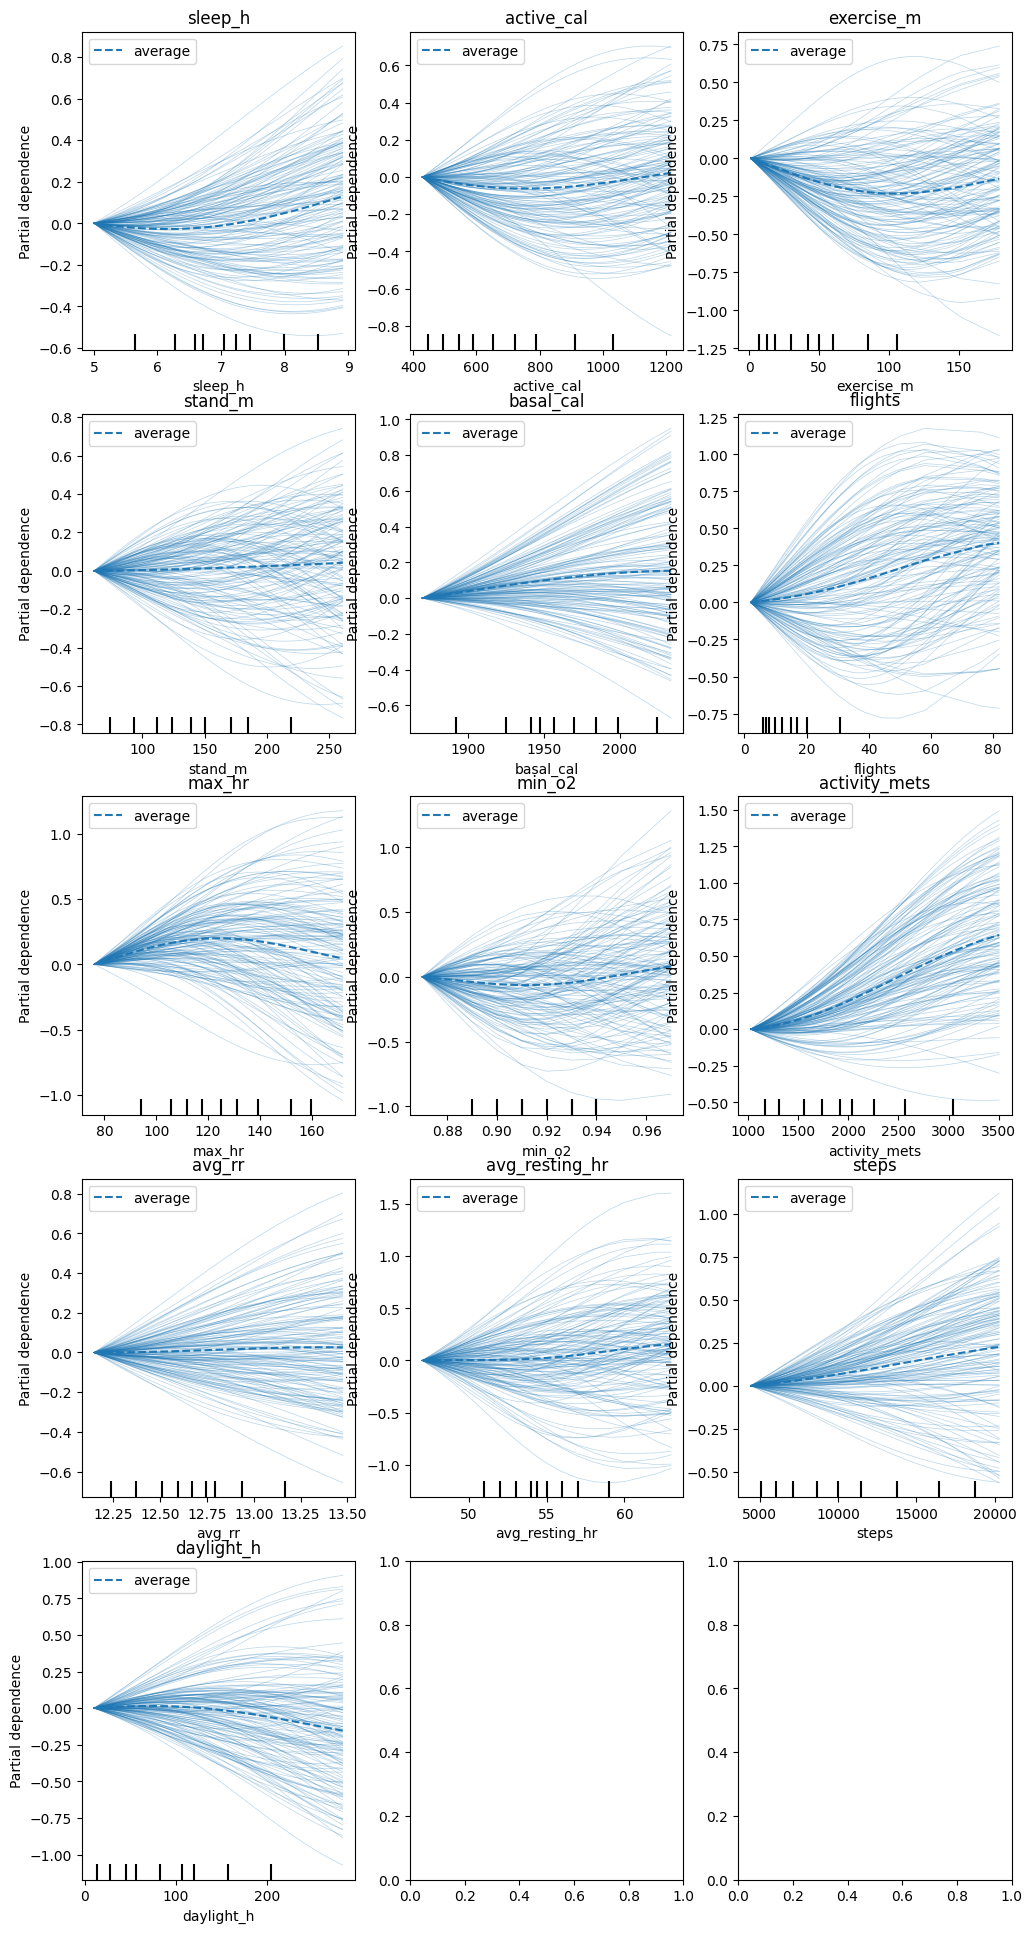

In [192]:
h = 5
w = 3
fig, axs = plt.subplots(h,w, figsize=(12,24))
for i, feature in enumerate(X_test.columns): 
    row = i // w
    col = i % w    
        
    pdp = PartialDependenceDisplay.from_estimator(reg_pipe, X_test, [feature], kind='both', centered=True, ax=axs[row, col])
    axs[row, col].set_title(feature)    

plt.show()
fig.tight_layout()

These tell the same story. Interestingly, the slight inverse relationship between active calories expended and sleep duration is hard to explain. As pointed out before, we have some collinearities that may be leading the model to attribute all positive effects in a colinearity to one feature and negative effects to another. This is an indicator we may want to retrain this model with fewer features. We'll tuck the most prominent features away for further inspection with another techqnique below. 

In [206]:
positive_features = [
    'activity_mets', 
    'flights',
    'sleep_h',
    'steps'
]

negative_features = [
    'daylight_h',
    'exercise_m'
]

### Anchors

In [193]:
from anchor import anchor_tabular

Anchors are looking for plausible, minimum number of feature and the associated values that stay consistent as other parameters vary. This yields a plausible story about why the predition a specific point (input) is being made. 

In [194]:
explainer = anchor_tabular.AnchorTabularExplainer( 
    class_names=[],     
    feature_names=X_test.columns, 
    train_data=X_test.to_numpy(), 
    categorical_names={} # We have no categorical features
)

Let's look at our test data and pick a day to inspect more closely with anchors.

In [195]:
X_test

sleep_h  active_cal  exercise_m  stand_m  basal_cal  flights  max_hr  \
2704  7.925000     420.346        17.0     85.0   1943.473     16.0   125.0   
2034  8.475000     486.793        19.0    136.0   1947.226     11.0    99.0   
2301  8.558333     477.905        13.0     83.0   1967.725     16.0   148.0   
2457  7.641667     759.848        46.0    177.0   1963.964      9.0   115.0   
2634  0.375000     431.178         9.0    110.0   1263.087      6.0   111.0   
...        ...         ...         ...      ...        ...      ...     ...   
2071  7.058333     528.417        11.0    112.0   2001.237      9.0   107.0   
2193  6.933333     845.553        49.0    188.0   1969.802     22.0   156.0   
2329  7.683333     921.916        98.0    161.0   1970.195     45.0   128.0   
2166  7.033333     590.468        11.0    186.0   1940.586     10.0   112.0   
2136  7.675000     446.545         3.0    109.0   1984.640      5.0    90.0   

      min_o2  activity_mets     avg_rr  avg_resting_hr    steps  daylight_h  
2704    0.94         1199.3  12.372340            59.0   7131.0    86.00000  
2034    0.87         1730.0  12.764151            54.0   6690.0   138.00000  
2301    0.92         1243.4  12.678571            55.0   6433.0    22.00000  
2457    0.93         1923.4  12.302083            56.0  16193.0    10.00000  
2634    0.93         1460.2  13.900000            56.0  10519.0   175.00000  
...      ...            ...        ...             ...      ...         ...  
2071    0.90         1556.5  13.155556            59.0   6150.0    16.00000  
2193    0.93         3210.7  12.608696            57.0  17888.0   160.00000  
2329    0.88         2898.5  13.000000            57.0  26116.0   204.00000  
2166    0.92         2364.5  13.085106            53.0  11337.0   106.93037  
2136    0.90         1023.0  12.510417            56.0   5753.0   157.00000  

[147 rows x 13 columns]

Let's take the first day, ~8h of sleep the night before, limited exercis, below average METs. 

In [196]:
sample_ix = 0
sample_X = X_test.iloc[sample_ix].to_numpy()
sample_pred = cls_pipe.predict([sample_X])[0]

/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


Build the anchor instance explainer and then pull the anchor description. 

In [197]:
exp = explainer.explain_instance(sample_X, cls_pipe.predict, threshold=0.80)

/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/jason/Projects/School/medex/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does n

In [198]:
anchor_desc = ' AND '.join(exp.names())
pred_desc = sleep_classes[sample_pred]
print(f"For the below input data, the predicted class is {pred_desc}.\n{X_test.iloc[0]}")
print(f"\nThe generated anchor that describes the logic for this sample: '{anchor_desc}'")
print('Precision: %.2f' % exp.precision())
print('Coverage: %.2f' % exp.coverage())

For the below input data, the predicted class is 6.5-7.5.
sleep_h              7.92500
active_cal         420.34600
exercise_m          17.00000
stand_m             85.00000
basal_cal         1943.47300
flights             16.00000
max_hr             125.00000
min_o2               0.94000
activity_mets     1199.30000
avg_rr              12.37234
avg_resting_hr      59.00000
steps             7131.00000
daylight_h          86.00000
Name: 2704, dtype: float64

The generated anchor that describes the logic for this sample: 'steps <= 10012.00 AND avg_resting_hr > 56.50'
Precision: 0.86
Coverage: 0.09


This is so interesting! Let's look at the distributions of the two features. 


<Axes: >

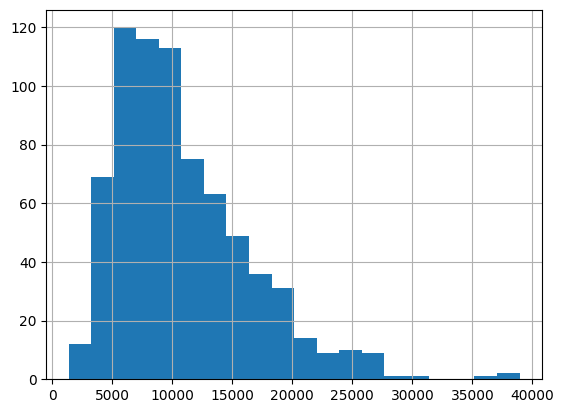

In [199]:
df2.steps.hist(bins=20)

<Axes: >

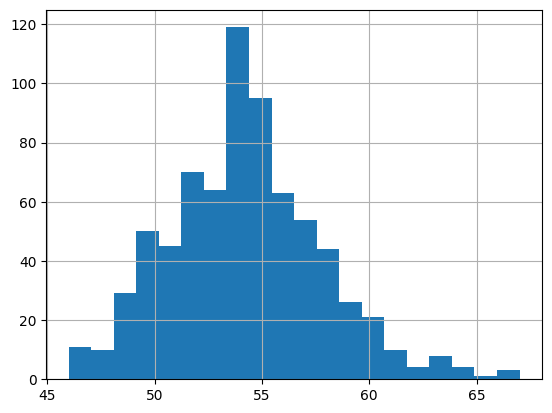

In [200]:
df2.avg_resting_hr.hist(bins=20)

Here an above average count of steps and an above-average resting heart rate are pinpointed as the primary drivers of the prediction. Both are proxies for exercise perhaps, and on a day with little activity perhaps these are the major drivers. 

### ALE

Finally we'll look at accumulated local effects (ALE) plots to get a macro view on the model's decision story for a given feature. 

In [201]:
from alepython import ale_plot

Let's start with a check on the two features reported for the above sample. 

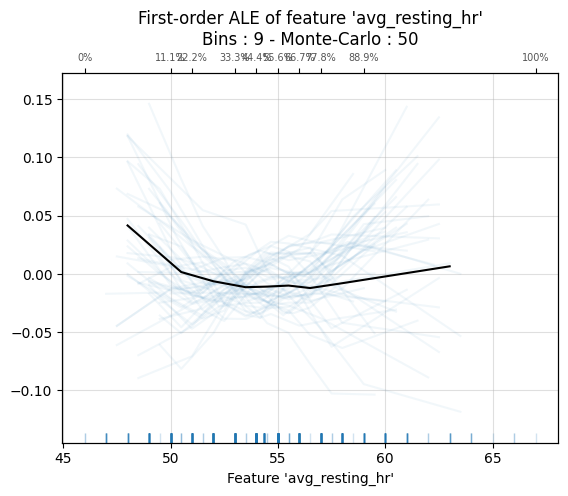

In [202]:
_ = ale_plot(reg_pipe, X_train, 'avg_resting_hr', monte_carlo=True)

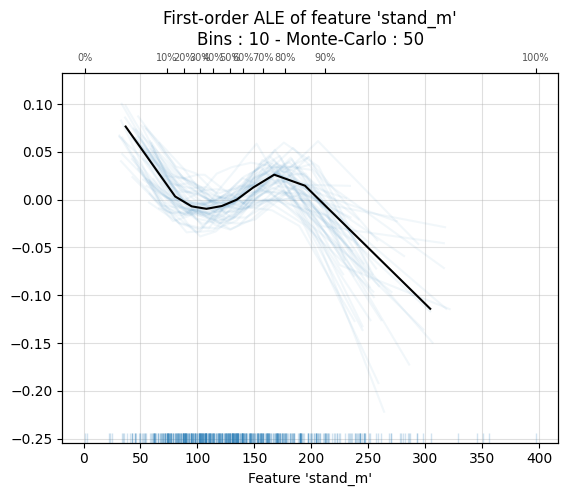

In [203]:
_ = ale_plot(reg_pipe, X_train, 'stand_m', monte_carlo=True)

While ALE seems to concur with the anchor that stand minutes have varying impact on sleep predictions, it tells a different story for resting heart rate, which seems to vary little and drive little in the way of outcomes (small magnitude and lower variance). 

Let's return to the ICE plot of activity, which suggested a counterintuive negative relationship to predicted sleep hours. 

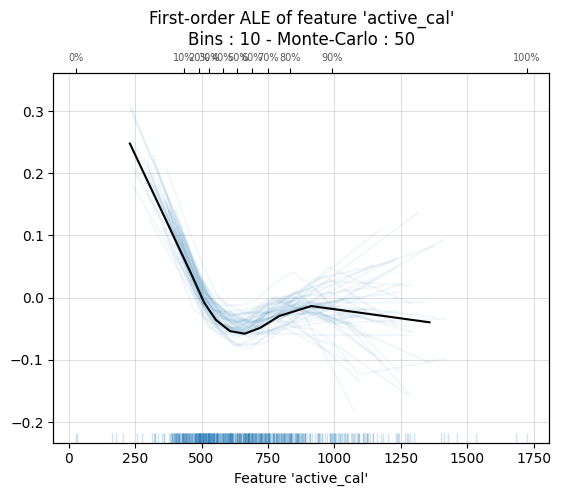

In [204]:
_ = ale_plot(reg_pipe, X_train, 'active_cal', monte_carlo=True)

## Thoughts

A logical step to assess the explainability methods is to stack them up against one another. Here we look at the global explanations for feature relevance provided by ALE and ICE to assess their alignment. 

-----
Feature activity_mets:


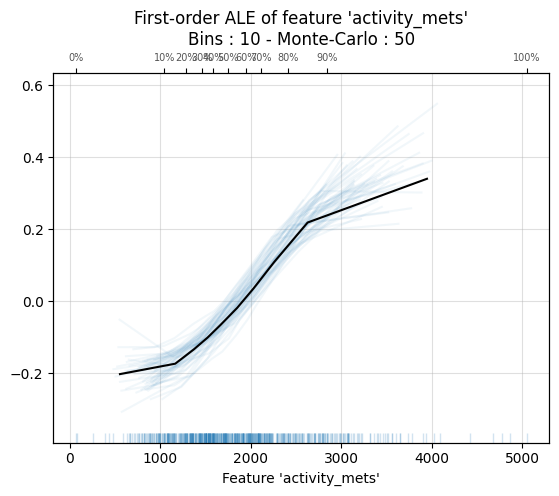

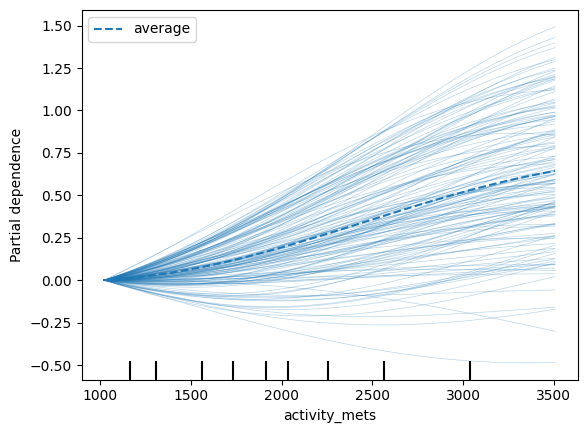

-----
Feature flights:


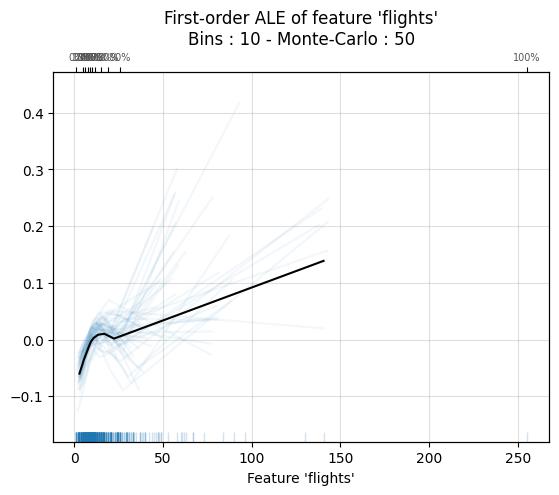

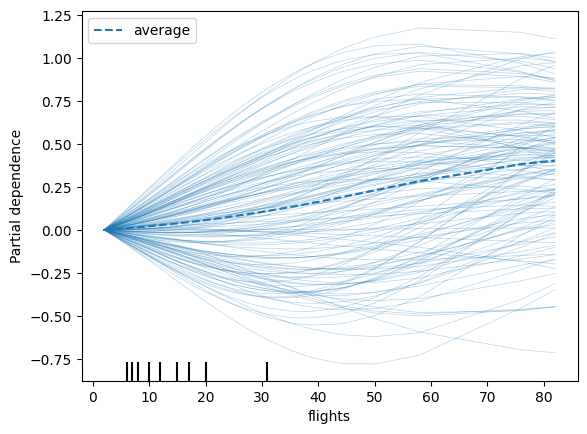

-----
Feature sleep_h:


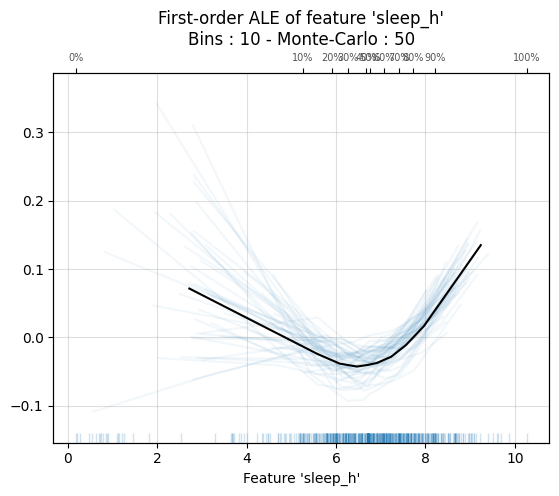

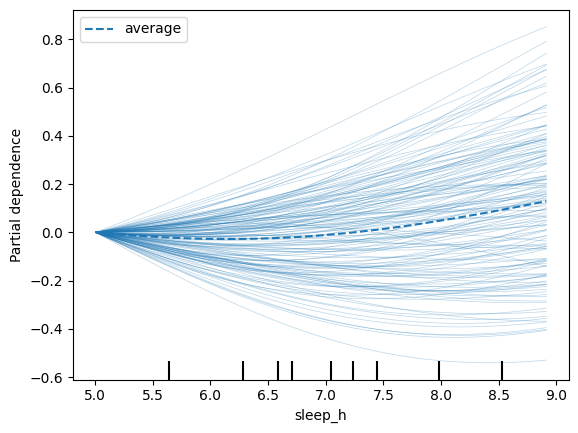

-----
Feature steps:


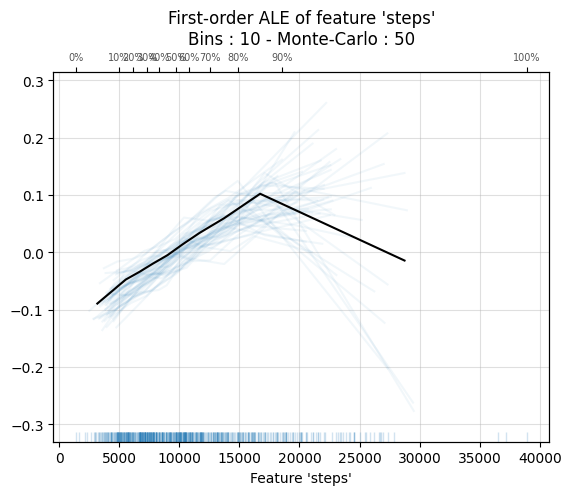

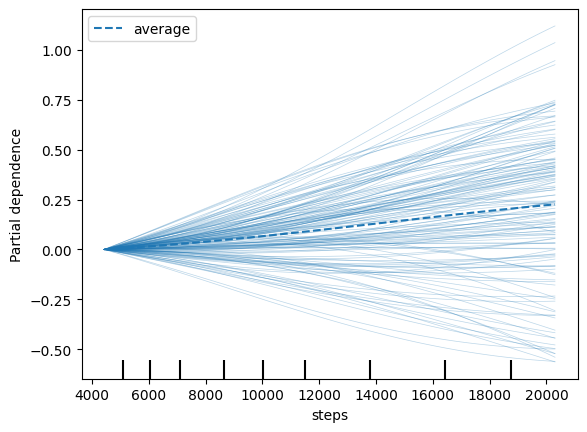

In [209]:
for positive in positive_features: 
    print(f"-----\nFeature {positive}:")
    _ = ale_plot(reg_pipe, X_train, positive, monte_carlo=True)
    plt.show()
    pdp = PartialDependenceDisplay.from_estimator(reg_pipe, X_test, [positive], kind='both', centered=True)
    plt.show()


The ICE plots indicate a monotonically increasing relationship between each of these 'positive' features, and the ALE plots mostly agree save the last which the explain has suggested turns inverse after a certain threshold. 

We'll look side by side at the features we saw a mostly negative correlation to earlier also below. 

-----
Feature steps:


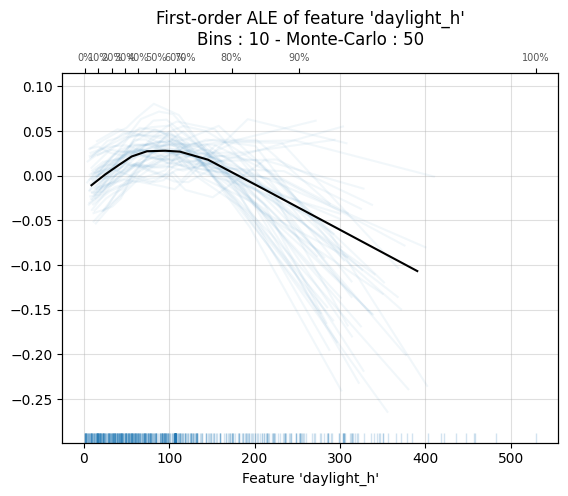

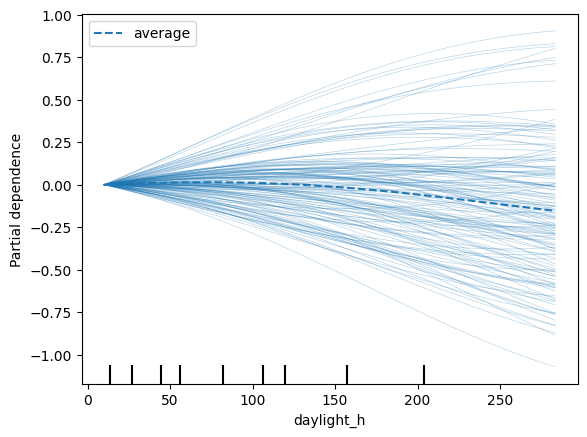

-----
Feature steps:


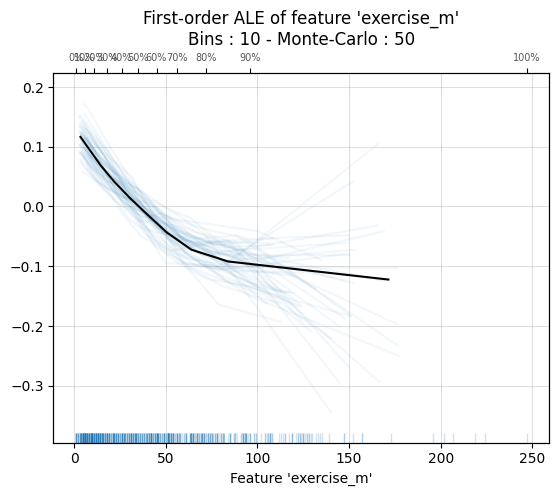

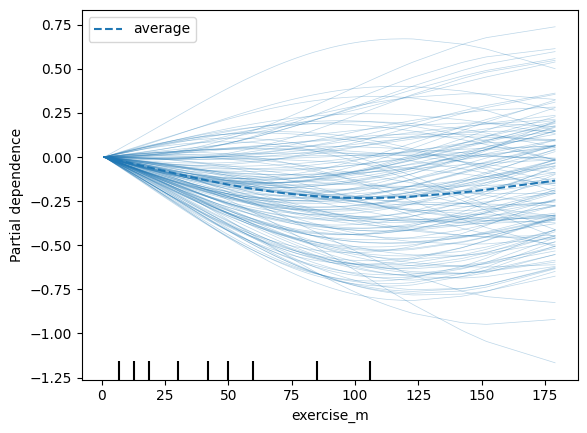

In [210]:
for negative in negative_features: 
    print(f"-----\nFeature {positive}:")
    _ = ale_plot(reg_pipe, X_train, negative, monte_carlo=True)
    plt.show()
    pdp = PartialDependenceDisplay.from_estimator(reg_pipe, X_test, [negative], kind='both', centered=True)
    plt.show()


These two features the explanation seems more consistent on, with both ICE and ALE picking up on non-linearities that may be useful for studying further. 

**Overall**, there are plenty of intuitions about what ought to drive sleep duration, and I've only made some of the relevant factors available to the model. The reported accuracy though gives confidence that the models are learning an underlying pattern that is worth paying attention to. Interestingly, I have no desire to use the model for prediction, as knowing how much I'm supposed to sleep before going bad is a recipe for a night of neuroticism. However the models are quite useful for *inference*. The amplifying information mined with explainability techniques make a compelling case for building a better model, as appreciating the factors that drive sleep duration (and down the road perhaps quality) opens the door to interventions. 